[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/BouleJaune/picselliaT/blob/master/notebookOBDTC.ipynb)



# Object-detection made easy
We will learn how to easily train an object detection model from a list of pre-trained models with the dataset you created on the picsell-IA platform.

In [ ]:
!git clone https://github.com/BouleJaune/picselliaT
%cd picselliaT/
!pip install picsellia
%tensorflow_version 1.x

In [ ]:
import gdown
gdown.download("https://drive.google.com/u/0/uc?export=download&confirm=sWbX&id=14UDmfWrnP2jwppxvcL6wkjPtObuuMh20", "models.zip", quiet=False)
!unzip models.zip

## Imports

In [1]:
import sys
sys.path.append("slim")
from picsellia import Client
import main
from util.infer import infer
import tensorflow as tf

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/ubuntu/anaconda3

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.







## List of possible models : 

- Mask RCNN, a segmentation model. String variable: 'mask_rcnn'
- Faster RCNN an accurate but slow object detection model. String variable: 'faster_rcnn'
- SSD Inception, a fast but less accurate object detection model. String variable : 'ssd_inception'

## Setup

We need to start setting up some variables before anything else.

In [3]:
token = "0bc6ff2f-7b9b-4656-be8b-5cd433ddbd7d" # Token from the picsell-IA platform
model_picked = "mask_rcnn" # Choose your base model here from the list of possible models
model_name = "test_model" # Name your to-be trained model
annotation_type = "polygon" # Chose the type of annotation used

batch_size = 1
learning_rate = None #You can let this value to None
nb_steps = 10
mask_type = 'PNG_MASKS' #Set this to 'PNG_MASKS' if you want to train a mask segmentation model.

## Client initialisation and data pre-processing

We communicate with the platform to create a new model and get the images and annotations.
With this we can generate the label map, smartly split our data then create the TFRecord files which will be used as input for the model. 

In [4]:
path_models = "models/"
model_selected = path_models + model_picked + "/"

clt = Client(token=token, host="https://backstage.picsellia.com/sdk/")
clt.init_model(model_name)

clt.dl_annotations()
clt.generate_labelmap()
clt.local_pic_save()

main.create_record_files(label_path=clt.label_path, record_dir=clt.record_dir, 
                         tfExample_generator=clt.tf_vars_generator, annotation_type=annotation_type)

Initializing Picsell.ia Client at https://backstage.picsellia.com/sdk/ ...
Connection established at https://backstage.picsellia.com/sdk/
Connection Established
It's your first training for this project
Annotations pulled ...
Generating labelmap ...
Label_map.pbtxt crée @ e510e6a1-6deb-487c-b401-1a9756eeac88/a057acfa-ad23-4aac-8228-252448727ada/0//label_map.pbtxt
['person', 'bycicle']
6 Images used for training, 2 Images used for validation
8 files were already on your machine
 0 PNG images have been downloaded to your machine
Sending repartition to Picsell.ia backend
Repartition send ..


Successfully created the TFRecords: e510e6a1-6deb-487c-b401-1a9756eeac88/a057acfa-ad23-4aac-8228-252448727ada/0/records/train.record
Successfully created the TFRecords: e510e6a1-6deb-487c-b401-1a9756eeac88/a057acfa-ad23-4aac-8228-252448727ada/0/records/eval.record


Here we edit the base protobuf configuration of our model with our parameters. 
We check if it the first training on this model to see if we should train from a previous checkpoint or not.

In [5]:
if clt.training_id!=0:
    previous_path = clt.base_dir.split("/")[:-1]
    previous_path[-1] = clt.training_id - 1
    model_selected = "{}/{}/{}/".format(*previous_path)+"checkpoint/"
    
main.edit_config(model_selected=model_selected, config_output_dir=clt.config_dir,
            record_dir=clt.record_dir, 
            label_map_path=clt.label_path, 
            masks=mask_type, 
            num_steps=nb_steps,
            batch_size=batch_size, 
            learning_rate=learning_rate,
            training_id=clt.training_id)



INFO:tensorflow:Writing pipeline config file to e510e6a1-6deb-487c-b401-1a9756eeac88/a057acfa-ad23-4aac-8228-252448727ada/0/config/pipeline.config


## Training

We can launch the training... and it's as easy as just telling the fonction where is the configuration file and where we want the checkpoints and records to be saved !

In [6]:
main.legacy_train(ckpt_dir=clt.checkpoint_dir, 
                     conf_dir=clt.config_dir)





Instructions for updating:
Please switch to tf.train.create_global_step




Instructions for updating:
Use `tf.data.experimental.parallel_interleave(...)`.
Instructions for updating:
Use `tf.data.Dataset.interleave(map_func, cycle_length, block_length, num_parallel_calls=tf.data.experimental.AUTOTUNE)` instead. If sloppy execution is desired, use `tf.data.Options.experimental_determinstic`.
Instructions for updating:
Use `tf.data.Dataset.map()

Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_initializable_iterator(dataset)`.


Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.Dataset.batch(batch_size)` (or `padded_batch(...)` if `dynamic_pad=True`).
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions for updating:
To 

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "







Instructions for updating:
Please switch to tf.train.get_or_create_global_step



Instructions for updating:
Please switch to tf.train.MonitoredTrainingSession
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from e510e6a1-6deb-487c-b401-1a9756eeac88/a057acfa-ad23-4aac-8228-252448727ada/0/checkpoint/model.ckpt-0
Instructions for updating:
Use standard file utilities to get mtimes.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Starting Session.
INFO:tensorflow:Saving checkpoint to path e510e6a1-6deb-487c-b401-1a9756eeac88/a057acfa-ad23-4aac-8228-252448727ada/0/checkpoint/model.ckpt
INFO:tensorflow:Starting Queues.
INFO:tensorflow:Recording summary at step 0.
INFO:tensorflow:global_step/sec: 0
INFO:tensorflow:global step 1: loss = 5.9402 (13.267 sec/step)
INFO:tensorflow:global step 2: loss = 5.6922 (0.158 sec/step)
INFO:tensorflow:global step 3: loss = 5.5189 (0.212 sec/step)
INFO:tensorflow:global step 4: loss = 2.0950 (4.591 sec/step)
INFO

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/summary/writer/writer.py:386: UserWarning: Attempting to use a closed FileWriter. The operation will be a noop unless the FileWriter is explicitly reopened.
  warnings.warn("Attempting to use a closed FileWriter. "


Now that the training has ended we want to send the logs to our dashboard so we can neatly see the sweet decrease of the loss. 

In [9]:
dict_log = main.tfevents_to_dict(path=clt.checkpoint_dir)
clt.send_logs(dict_log)

Training logs have been send to Picsell.ia Platform...
You can now inspect and showcase results on the platform.


## Exporting and infering

The model is trained but we still need to export it to a Tensorflow graph proto to use it.

In [10]:
tf.reset_default_graph()
main.export_infer_graph(ckpt_dir=clt.checkpoint_dir, 
                       exported_model_dir=clt.exported_model, 
                       pipeline_config_path=clt.config_dir,
                       write_inference_graph=True, input_type="image_tensor", input_shape=None)

INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:depth of additional conv before box predictor: 0
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
Instructions for updating:
`tf.batch_gather` is deprecated, please use `tf.gather` with `batch_dims` instead.
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Removing feature_maps from prediction_dict
Instructions for updating:
Use `tf.profiler.profile(graph, run_meta, op_log, cmd, options)`. Build `options` with `tf.profiler.ProfileOptionBuilder`. See README.md for details
Instructions for updating:
Use `tf.compat.v1.graph_util.tensor_shape_from_node_def_name`


260 ops no flops stats due to incomplete shapes.
260 ops no flops stats due to incomplete shapes.


INFO:tensorflow:Restoring parameters from e510e6a1-6deb-487c-b401-1a9756eeac88/a057acfa-ad23-4aac-8228-252448727ada/0/checkpoint/model.ckpt-10
INFO:tensorflow:Restoring parameters from e510e6a1-6deb-487c-b401-1a9756eeac88/a057acfa-ad23-4aac-8228-252448727ada/0/checkpoint/model.ckpt-10
Instructions for updating:
Use `tf.compat.v1.graph_util.convert_variables_to_constants`
Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`
INFO:tensorflow:Froze 360 variables.
INFO:tensorflow:Converted 360 variables to const ops.

Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.utils.build_tensor_info or tf.compat.v1.saved_model.build_tensor_info.




INFO:tensorflow:No assets to save.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: e510e6a1-6deb-487c-b401-1a9756eeac88/a057acfa-ad23-4aac-8228-252448727ada/0/exported_model/saved_model/saved_model.pb
INFO:tensorflow:Writing pip

Now we will use the exported model to do some inference on our evaluation set, then send the results to the dashboard.
You can set the minimum confidence treshold at which we keep the bounding boxes to the value you like the most.

Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.loader.load or tf.compat.v1.saved_model.load. There will be a new function for importing SavedModels in Tensorflow 2.0.
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:The specified SavedModel has no variables; no checkpoints were restored.


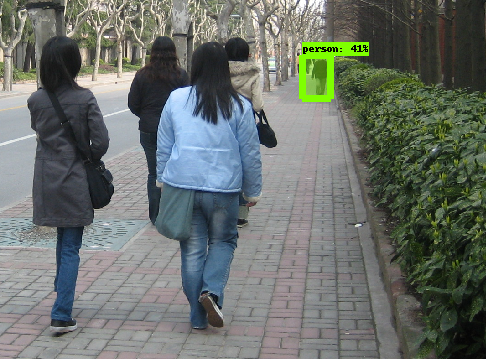

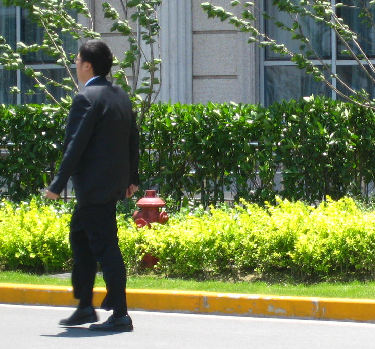

http: 204
http: 204
A snapshot of results has been saved to the platform


In [13]:
min_score_thresh = 0.3 
infer(clt.eval_list, exported_model_dir=clt.exported_model, 
          label_map_path=clt.label_path, results_dir=clt.results_dir, min_score_thresh=min_score_thresh, num_infer=16)
clt.send_examples()

In [ ]:
clt.send_weights(clt.exported_model+'saved_model/saved_model.pb')

[============================================>     ]]